In [1]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import torch
import torchaudio
import time
from scipy.io import loadmat

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, FDSTFT, entropy_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1802)
device

'cuda'

In [2]:
sr = 1e4
support = 2_000
stride = 100
lr = 10
winlength = 200
epochs = 1_000_000
threeshold = 0.001
patience = 99
start = 122
pas = 50
factor = 0.1

t = torch.arange(0, 2.5, 1 / sr)
f = torch.sin(2 * pi * t) + torch.ones_like(t) + 0.5 * t
f = f / f.max() * 0.5 * sr / 2

# plt.plot(f)
# plt.ylim(top=.5*sr, bottom=0)
# plt.xlim(left=0, right=25_000)

x = torch.sin(2 * pi * torch.cumsum(f / sr, dim=0))
x += torch.sin(2 * pi * torch.cumsum(0.8 / 2 * torch.ones_like(t), dim=0))
x += 0.1 * torch.randn(t.shape)

# plt.figure()
# plt.plot(x[:500])

x = x[None, ...].to(device)
# f = f.to(device)
print(x.shape)

winlengths = {}
wins = {}
times = {}
losses = {}

torch.Size([1, 25000])


In [3]:
wins = {}
times = {}
losses = {}

In [4]:
for winlength in range(start, support, pas):
    wins[winlength] = {}
    times[winlength] = {}
    losses[winlength] = {}

    dstft = FDSTFT(
        x,
        win_length=winlength,
        support=support,
        stride=stride,
        win_requires_grad=True,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    params = [{'params': dstft.win_length, 'lr': lr}]
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=opt,
        mode='min',
        factor=factor,
        patience=patience,
        verbose=False,
    )

    min_err = 100
    min_win = 0

    wins[winlength]['autodiff (pytorch)'] = []
    times[winlength]['autodiff (pytorch)'] = []
    losses[winlength]['autodiff (pytorch)'] = []

    for epoch in range(epochs):
        start_time = time.time()
        opt.zero_grad()
        spec, stft, *_ = dstft(x)

        x1 = torch.reshape(spec, (spec.shape[0], -1))  # B, N
        x1sum = x1.sum(dim=-1)
        probs = torch.div(x1.T, x1sum).T  # B, N
        log_probs = torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
        entropy = -(probs * log_probs).sum(dim=-1)  # B
        err = entropy.mean()

        err.backward()
        dt = time.time() - start_time

        # grads[winlength]['autodiff (pytorch)'].append(dstft.win_length.grad.item())
        times[winlength]['autodiff (pytorch)'].append(dt)
        losses[winlength]['autodiff (pytorch)'].append(err.item())
        wins[winlength]['autodiff (pytorch)'].append(dstft.win_length.item())

        opt.step()
        sch.step(err)

        if err < min_err:
            min_err = err
            min_win = dstft.win_length.item()

        if opt.param_groups[0]['lr'] < threeshold:
            break

    print(winlength, epoch, f'{dstft.win_length.item():.3f}')
    # dstft.print(spec, x, bar=True, wins=False, weights=False)
    # dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)

122 618 498.696
172 572 498.680
222 539 498.680
272 528 498.683
322 522 498.685
372 512 498.685
422 507 498.685
472 502 498.684
522 500 498.684
572 508 498.684
622 514 498.684
672 518 498.684
722 526 498.685
772 529 498.684
822 537 498.685
872 547 498.685
922 546 498.683
972 550 498.683
1022 565 498.684
1072 568 498.684
1122 576 498.685
1172 579 498.684
1222 586 498.684
1272 589 498.684
1322 593 498.684
1372 599 498.684
1422 608 498.683
1472 612 498.683
1522 616 498.683
1572 621 498.684
1622 627 498.684
1672 629 498.684
1722 634 498.684
1772 640 498.684
1822 643 498.684
1872 649 498.684
1922 647 498.684
1972 649 498.684


In [5]:
for winlength in range(start, support, pas):
    dstft = FDSTFT(
        x,
        win_length=winlength,
        support=support,
        stride=stride,
        win_requires_grad=True,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    params = [{'params': dstft.win_length, 'lr': lr}]
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=opt,
        mode='min',
        factor=factor,
        patience=patience,
        verbose=False,
    )

    min_err = 100
    min_win = 0

    wins[winlength]['analytical (ours)'] = []
    times[winlength]['analytical (ours)'] = []
    losses[winlength]['analytical (ours)'] = []

    for epoch in range(epochs):
        start_time = time.time()
        opt.zero_grad()
        spec, stft, *_ = dstft(x)

        x1 = torch.reshape(spec, (spec.shape[0], -1))  # B, N
        x1sum = x1.sum(dim=-1)
        probs = torch.div(x1.T, x1sum).T  # B, N
        log_probs = torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
        entropy = -(probs * log_probs).sum(dim=-1)  # B
        err = entropy.mean()

        start_time = time.time()
        dl_ds = (-(log_probs + err) / x1sum).reshape_as(spec) * stft / spec

        dl_dp = dstft.backward(x, dl_ds)
        dt = time.time() - start_time
        dstft.win_length.grad = dl_dp

        # grads[winlength]['analytical (ours)'].append(dstft.win_length.grad.item())
        times[winlength]['analytical (ours)'].append(dt)
        losses[winlength]['analytical (ours)'].append(err.item())
        wins[winlength]['analytical (ours)'].append(dstft.win_length.item())

        opt.step()
        sch.step(err)

        if err < min_err:
            min_err = err
            min_win = dstft.win_length.item()

        if opt.param_groups[0]['lr'] < threeshold:
            break

    print(winlength, epoch, f'{dstft.win_length.item():.3f}')
    # dstft.print(spec, x, bar=True, wins=False, weights=False)
    # dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)

122 618 498.718
172 572 498.702
222 539 498.702
272 528 498.705
322 522 498.707
372 512 498.707
422 507 498.706
472 502 498.706
522 500 498.706
572 508 498.706


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.74 GiB total capacity; 548.51 MiB already allocated; 12.62 MiB free; 580.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

122
172
222
272
322
372
422
472
522
572
622
672
722
772
822
872
922
972
1022


/tmp/ipykernel_45148/3109634758.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


1072
1122
1172
1222
1272
1322
1372
1422
1472
1522
1572
1622
1672
1722
1772
1822
1872
1922
1972


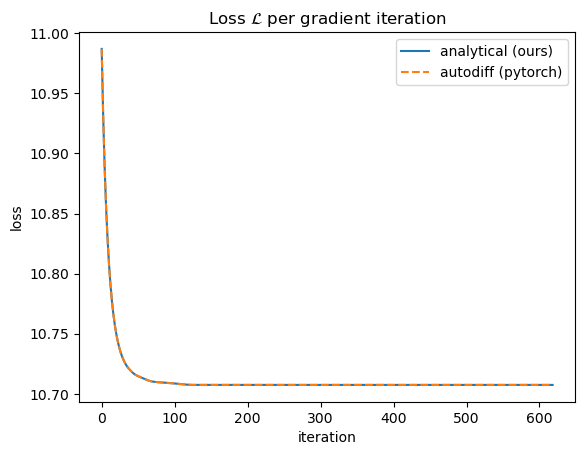

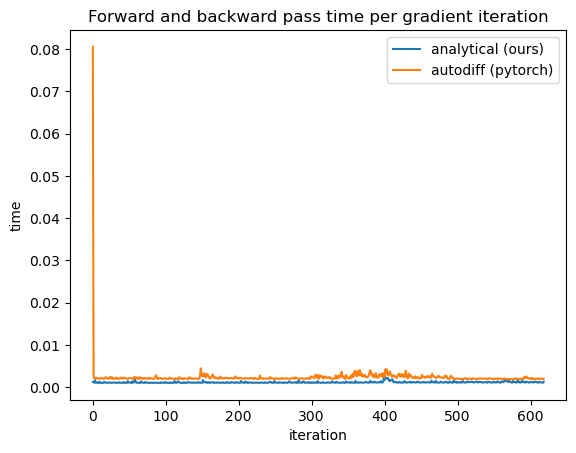

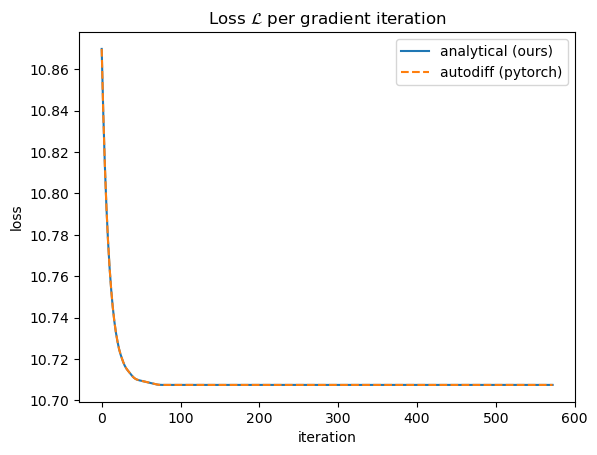

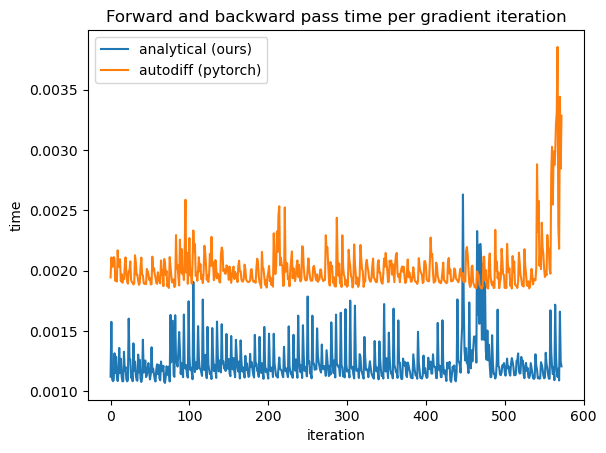

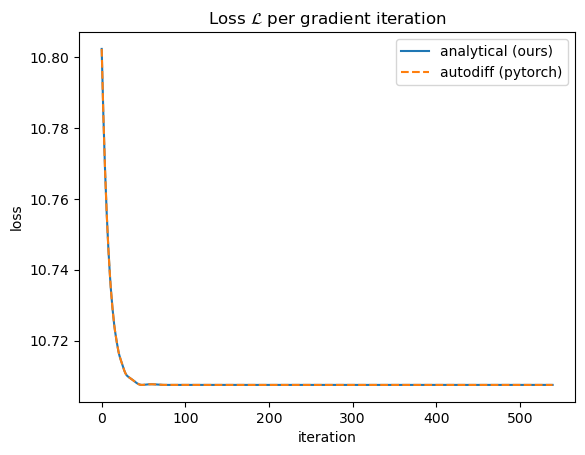

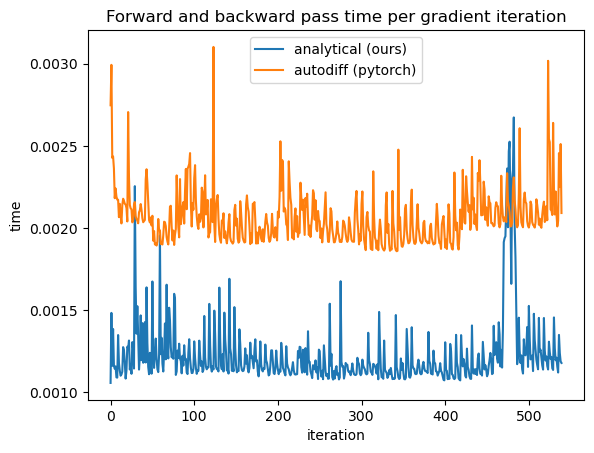

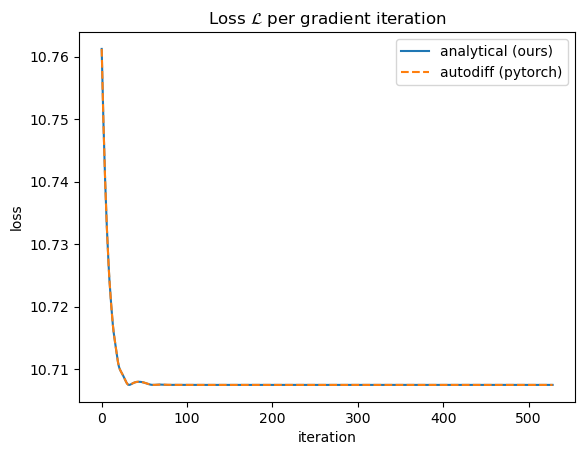

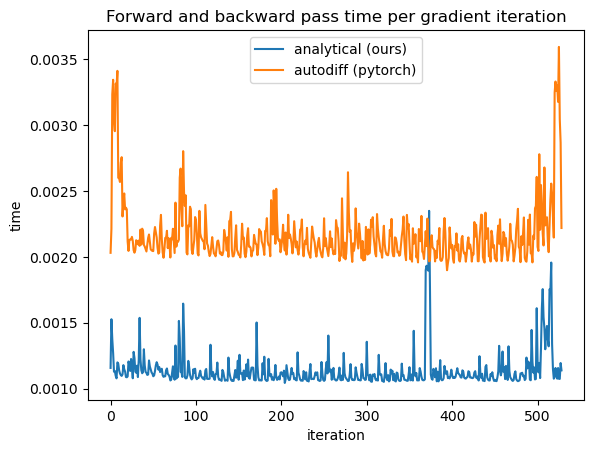

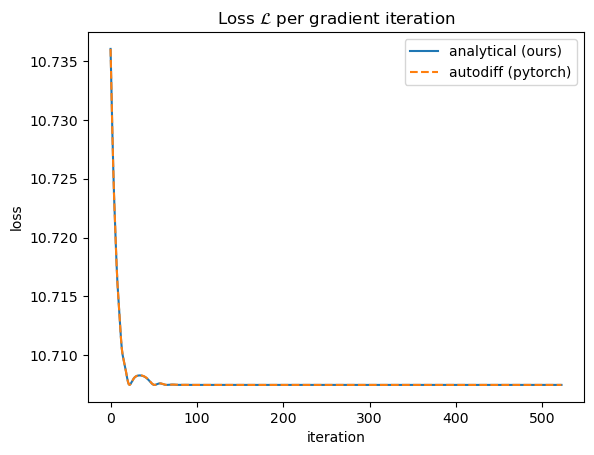

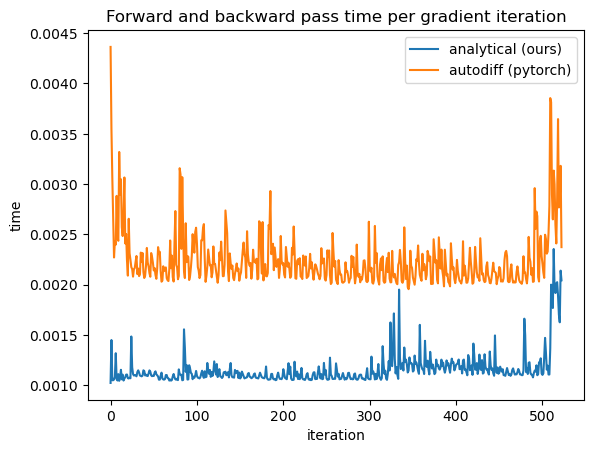

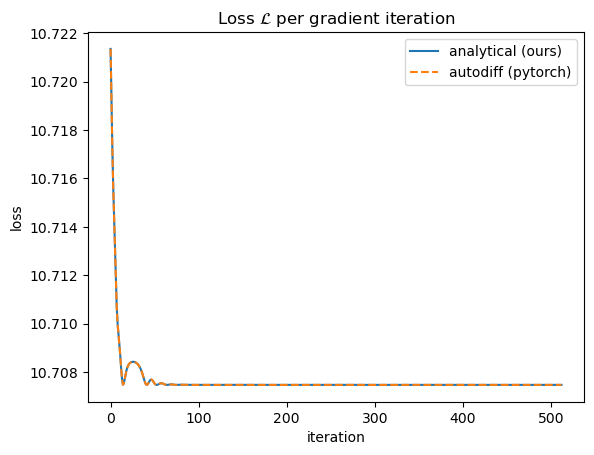

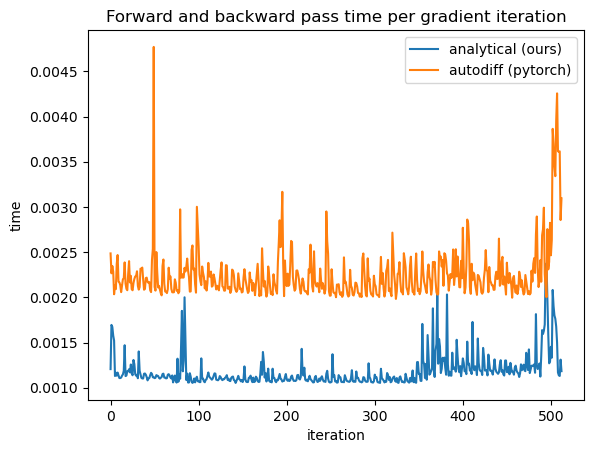

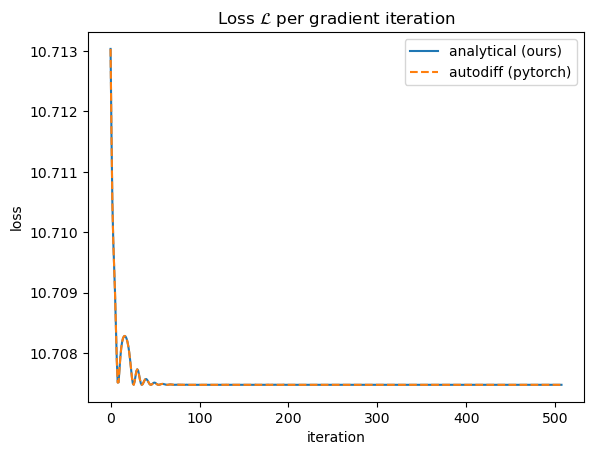

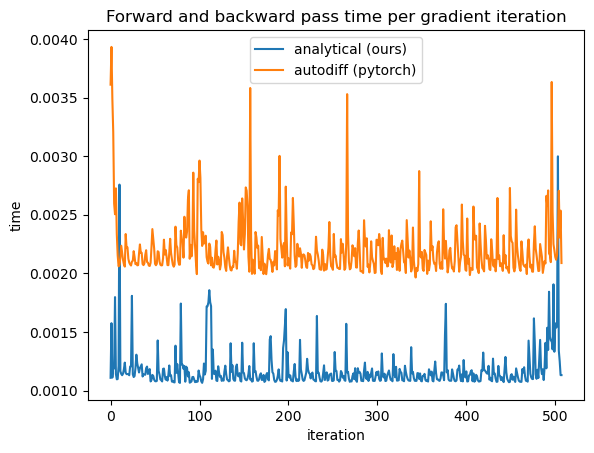

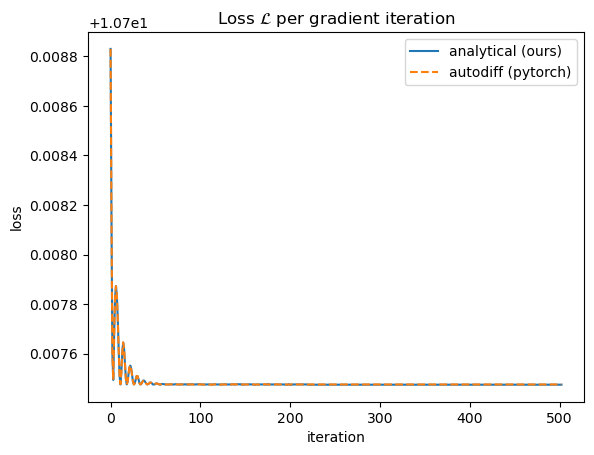

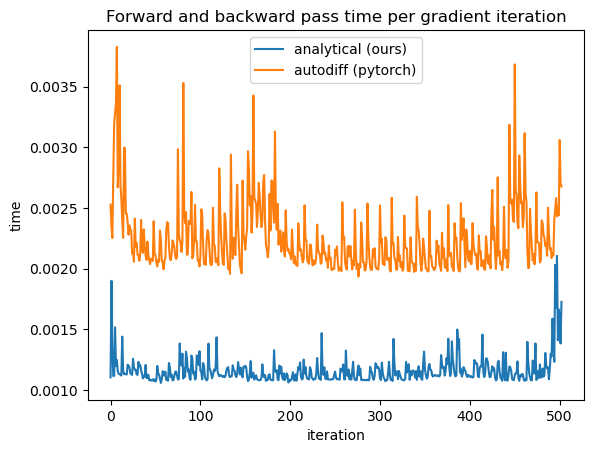

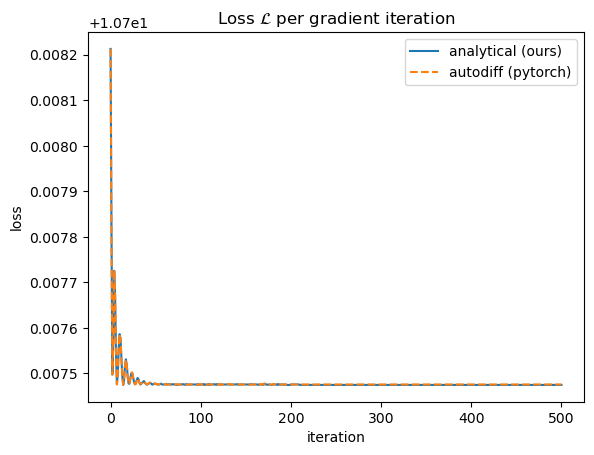

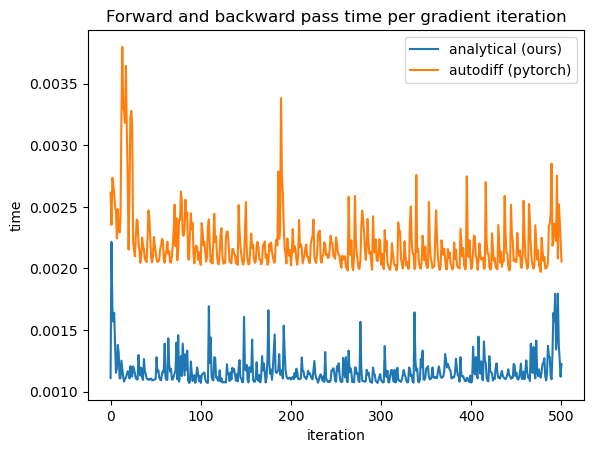

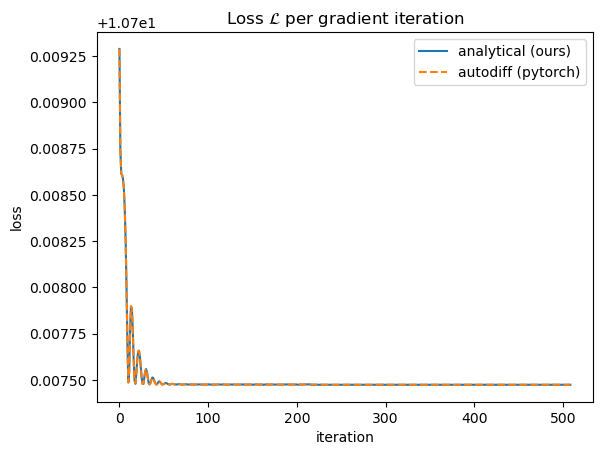

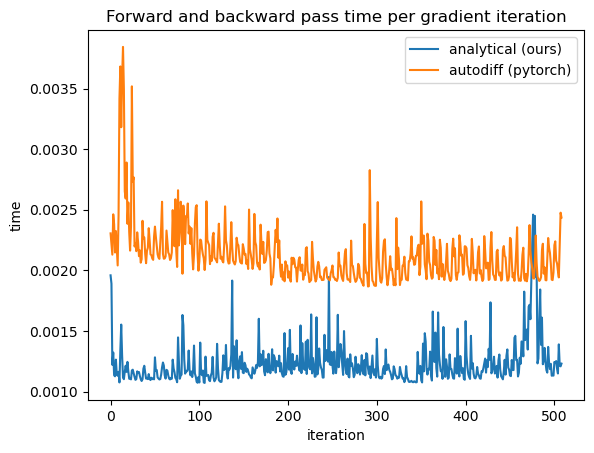

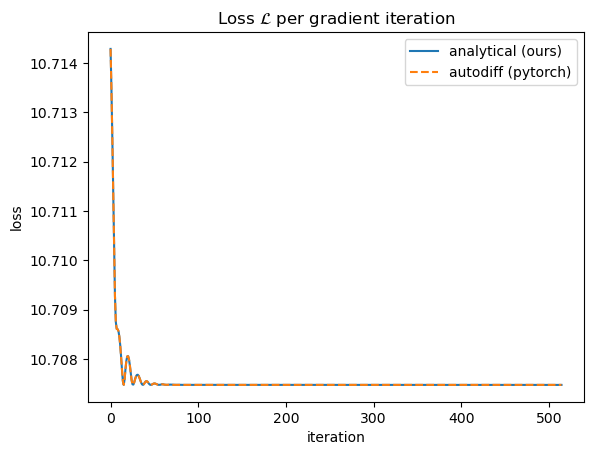

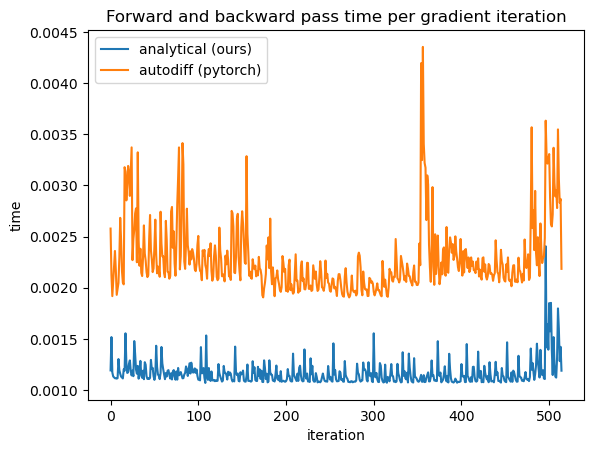

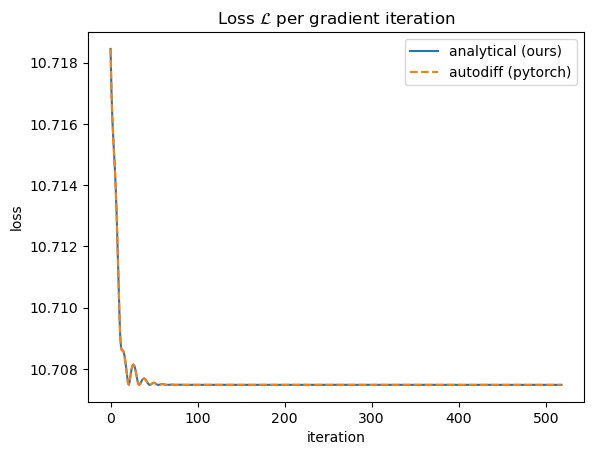

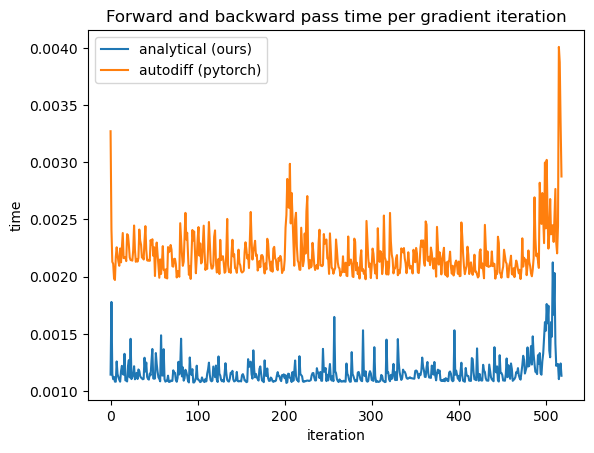

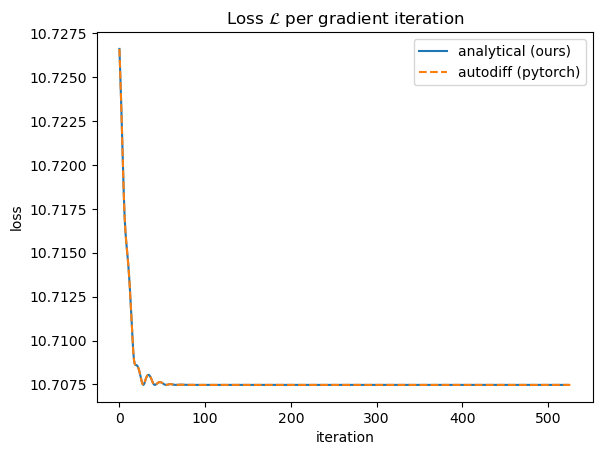

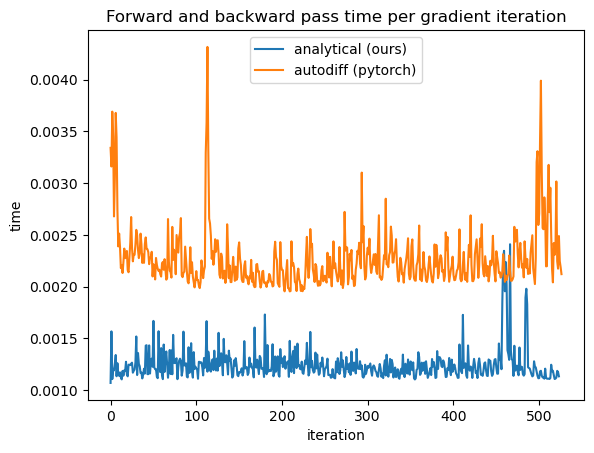

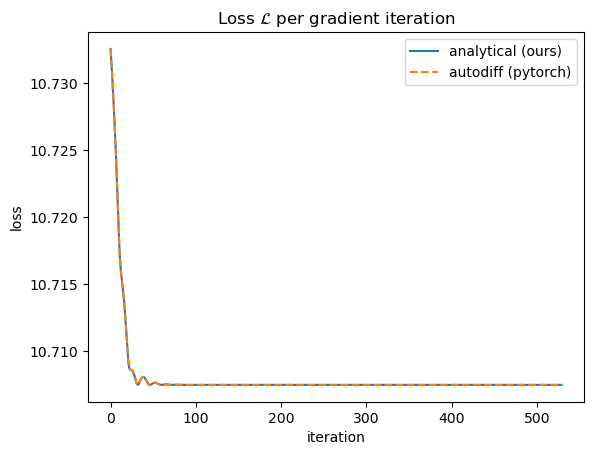

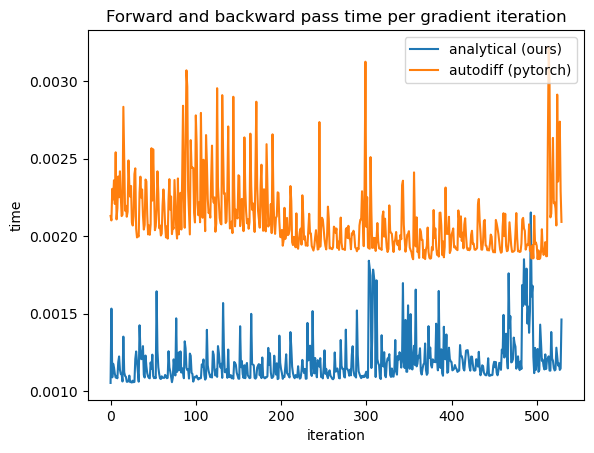

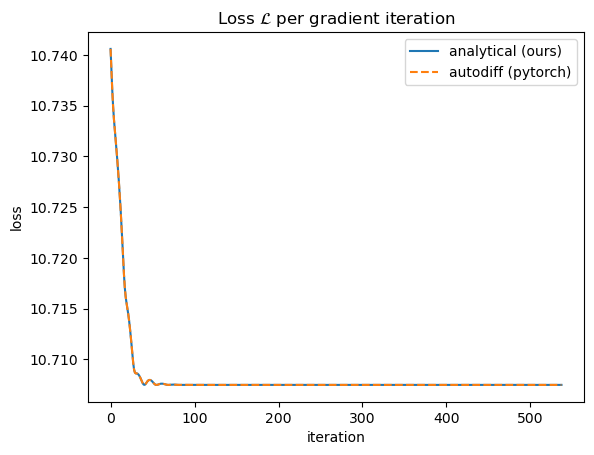

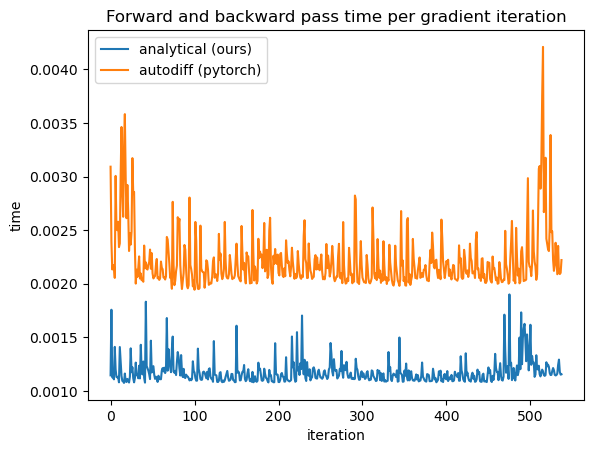

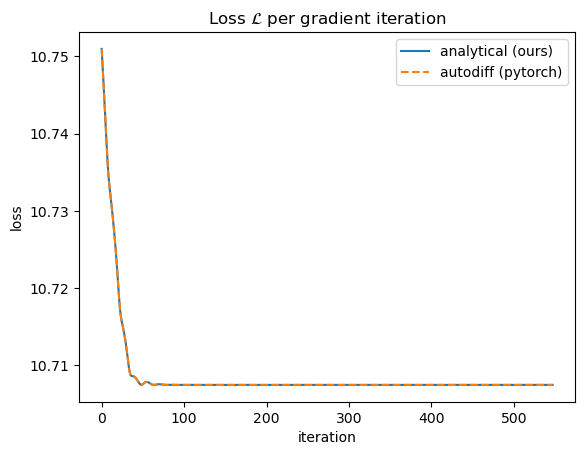

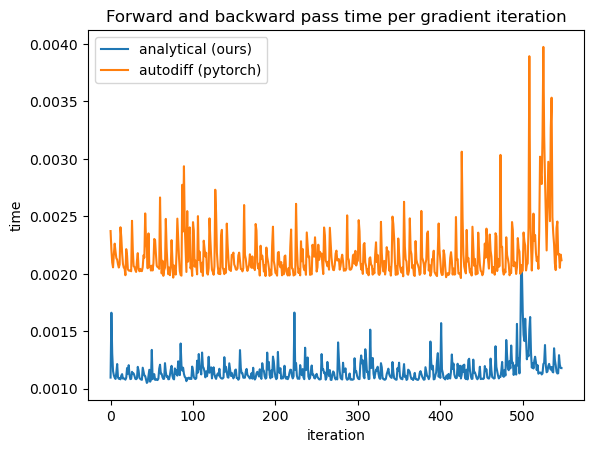

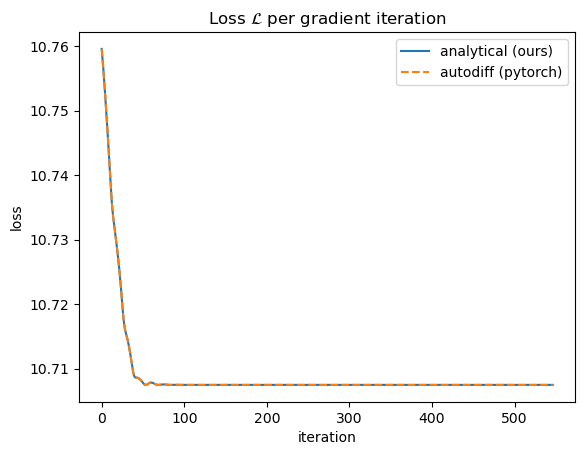

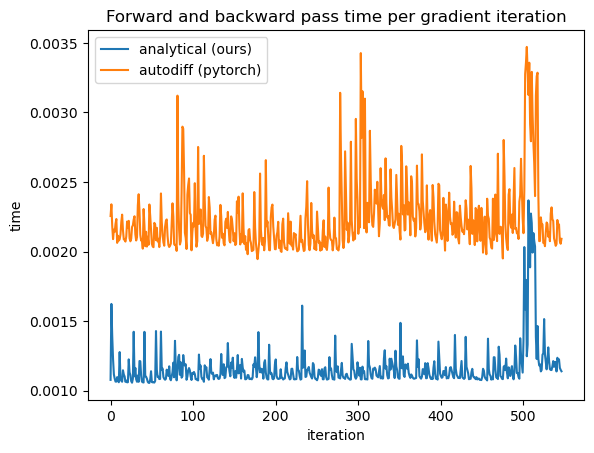

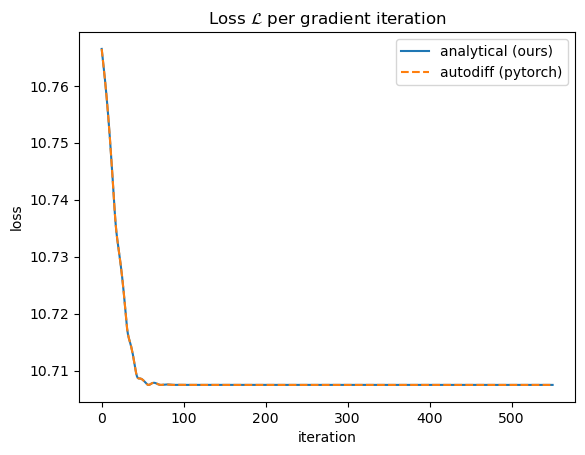

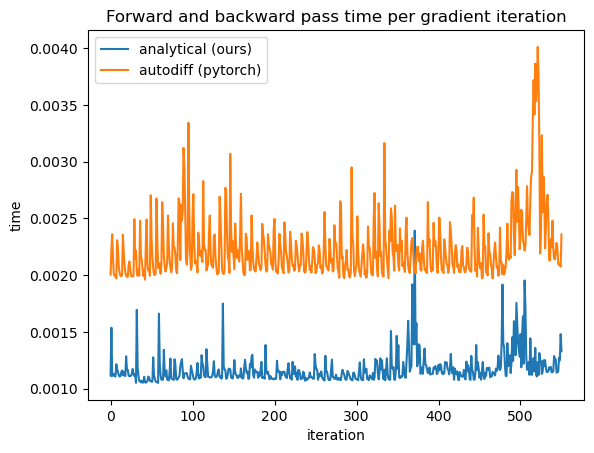

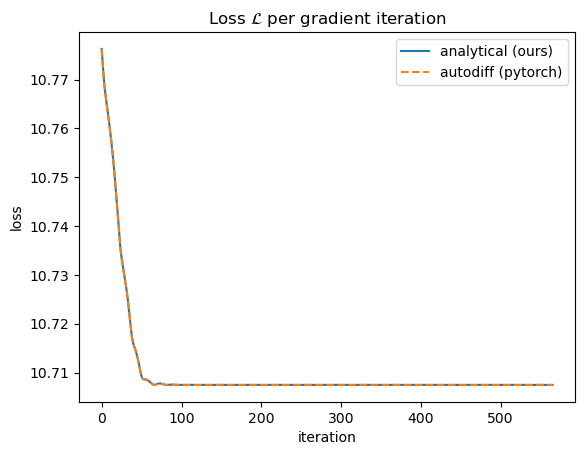

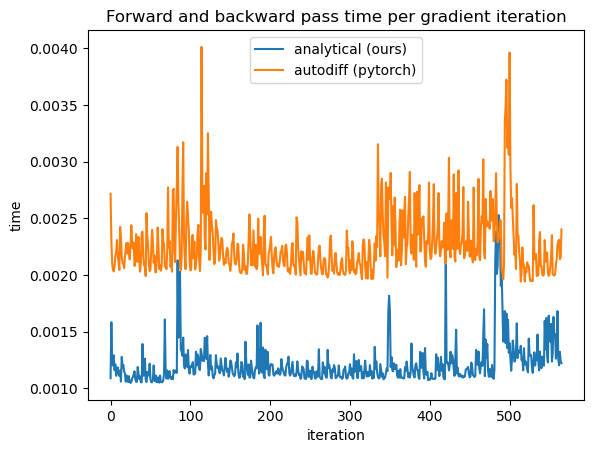

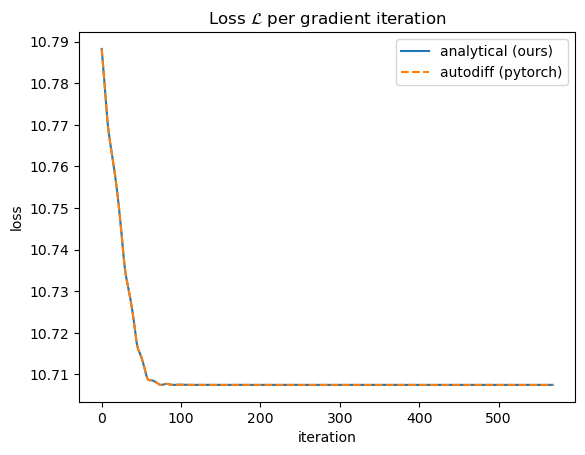

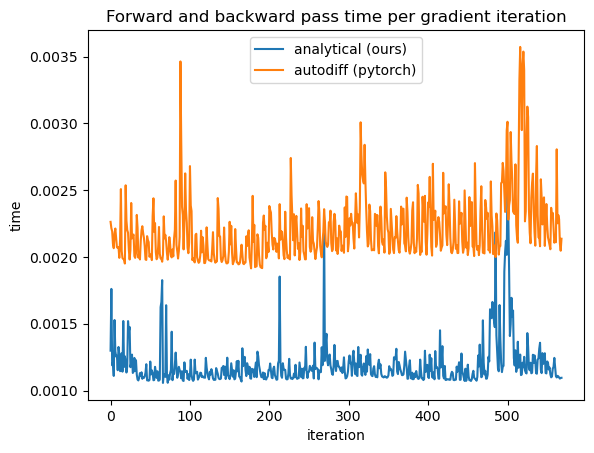

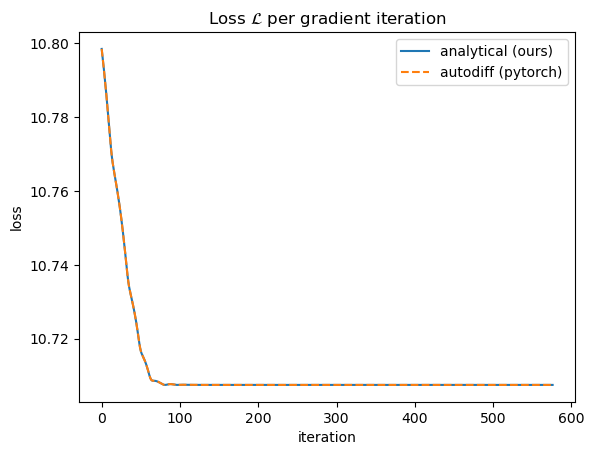

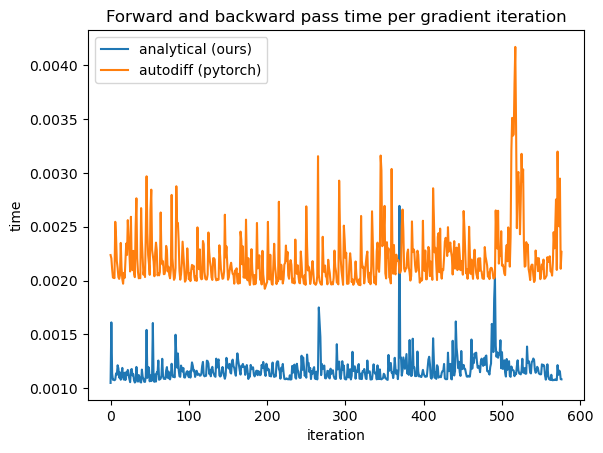

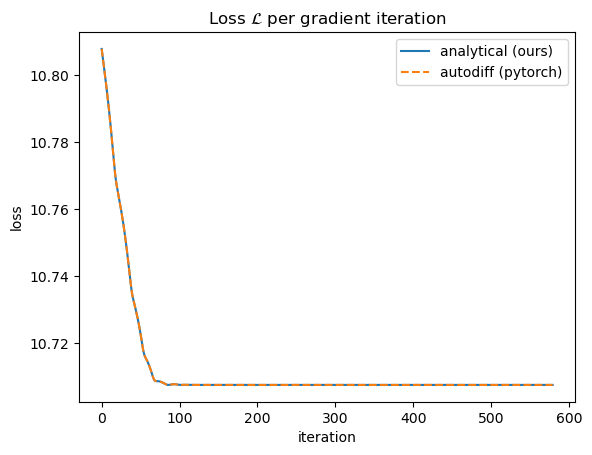

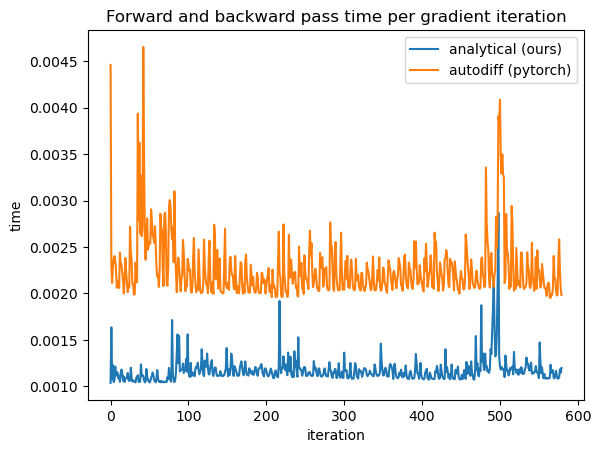

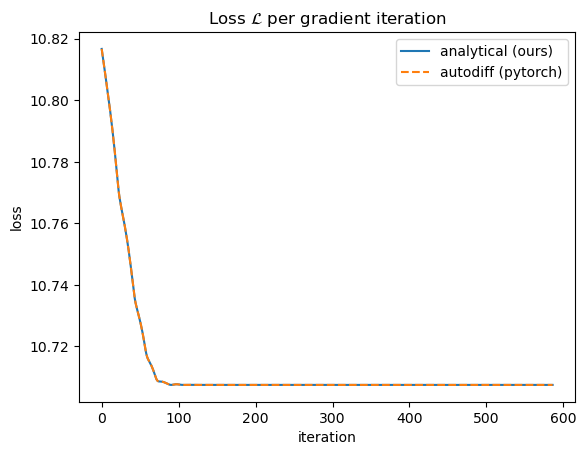

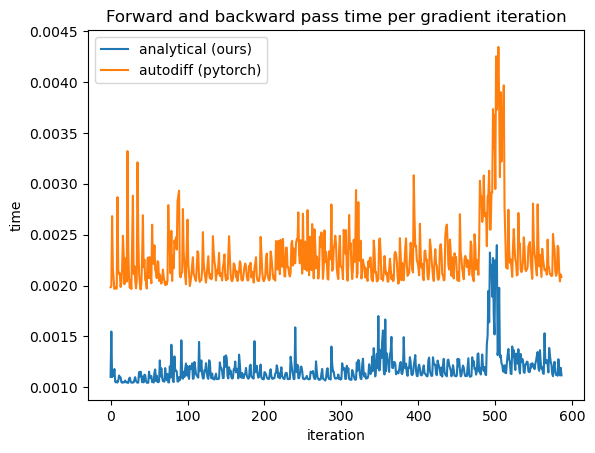

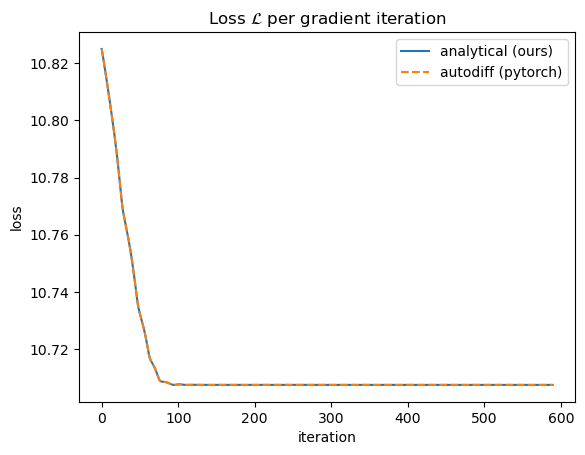

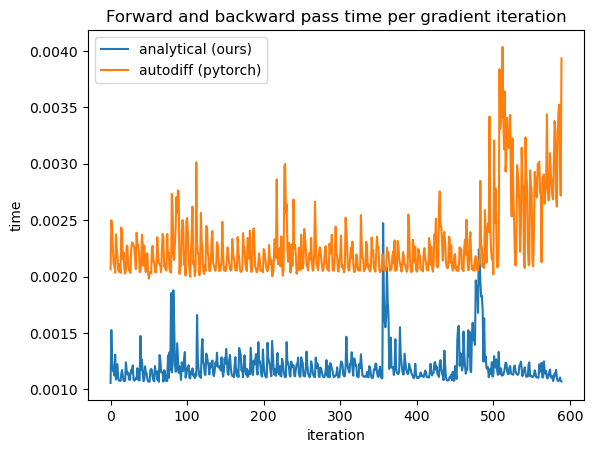

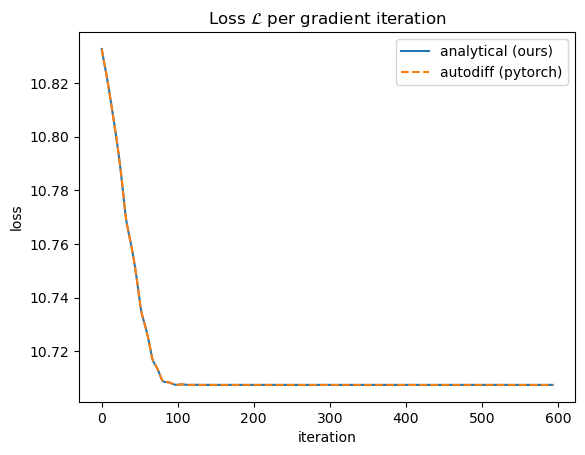

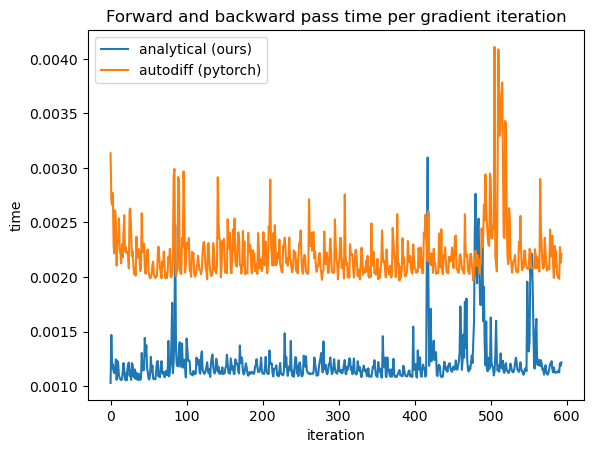

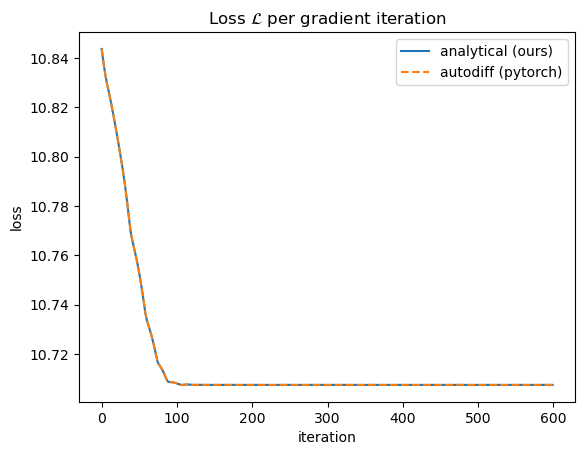

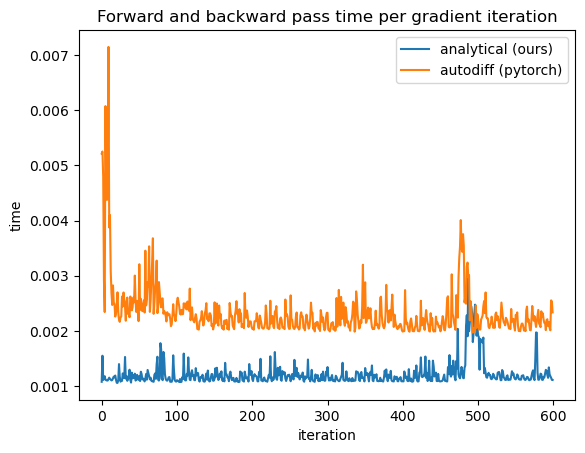

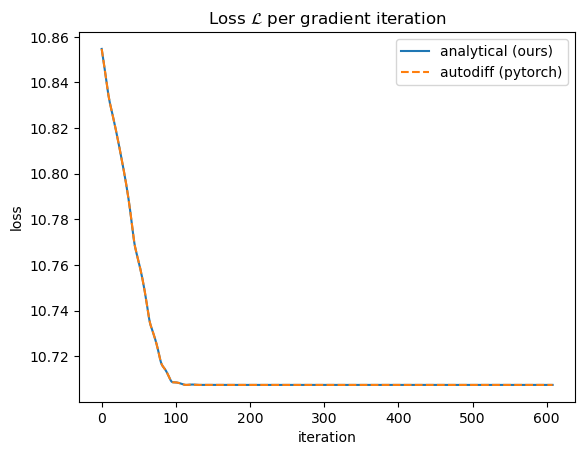

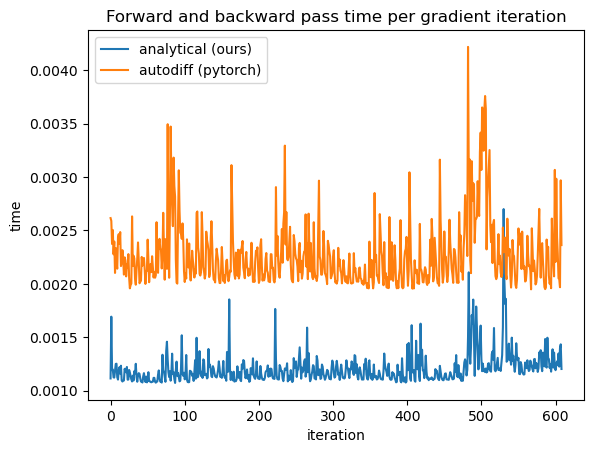

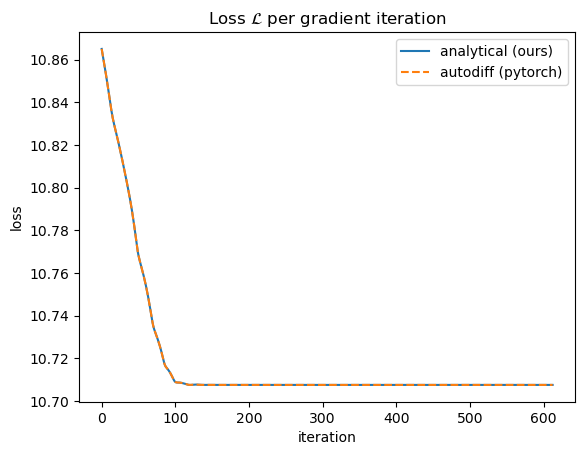

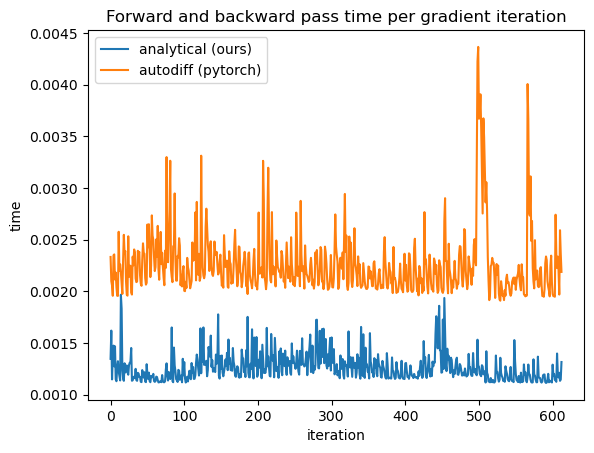

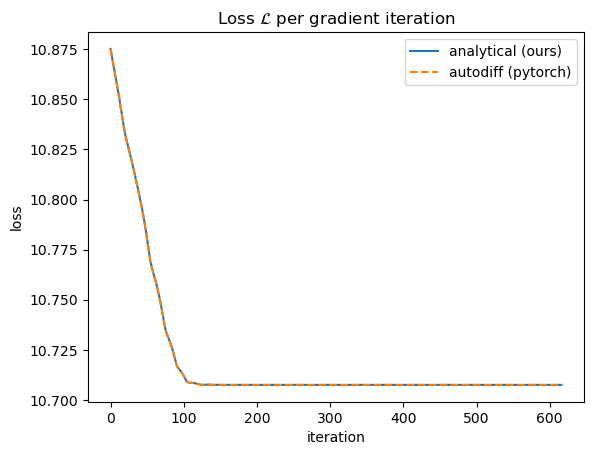

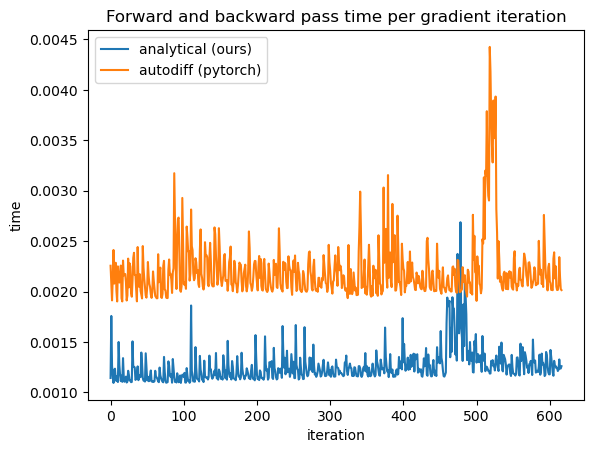

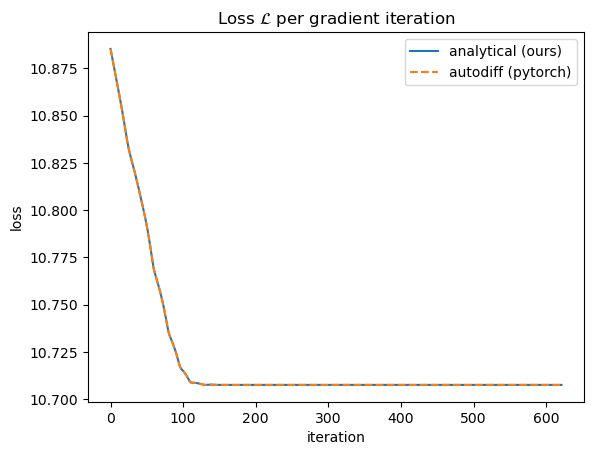

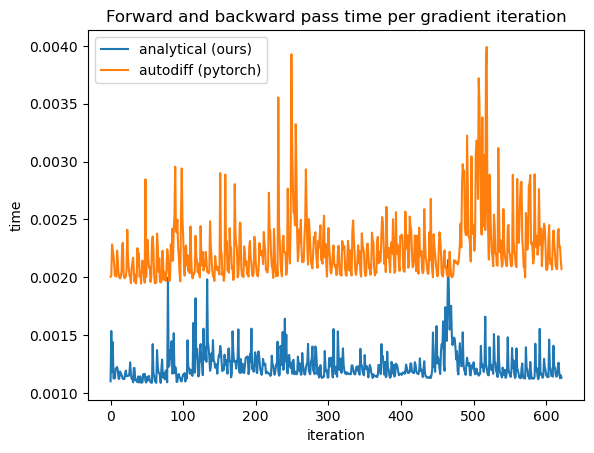

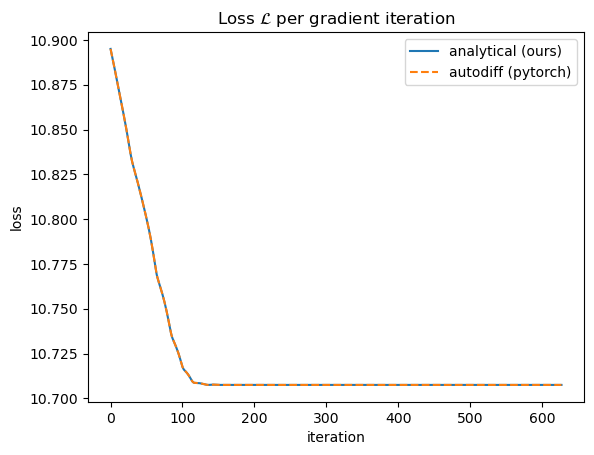

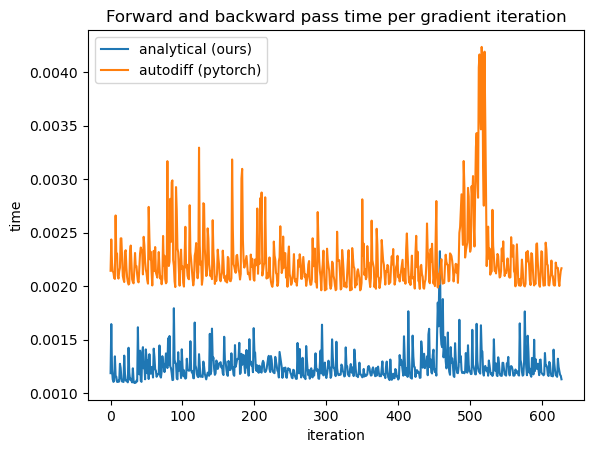

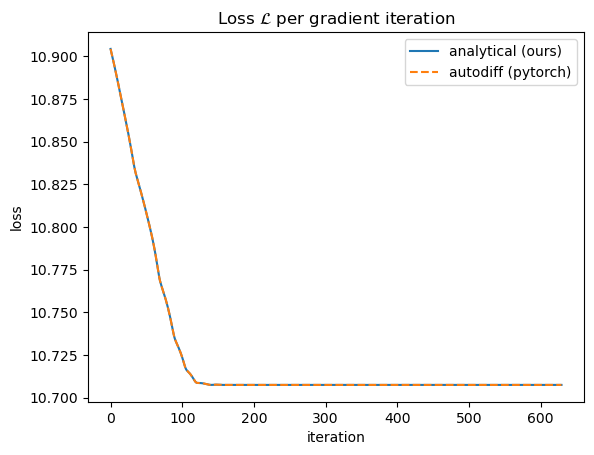

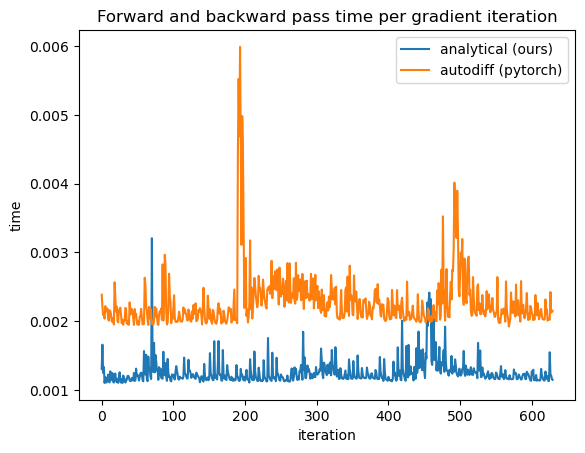

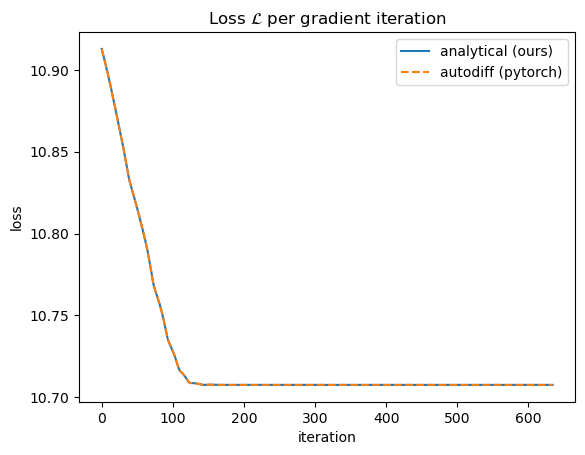

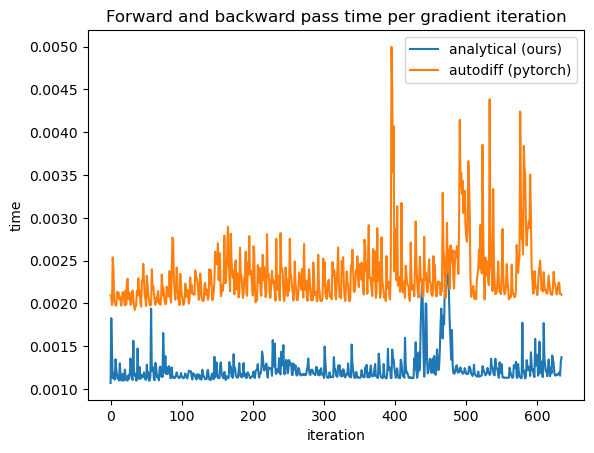

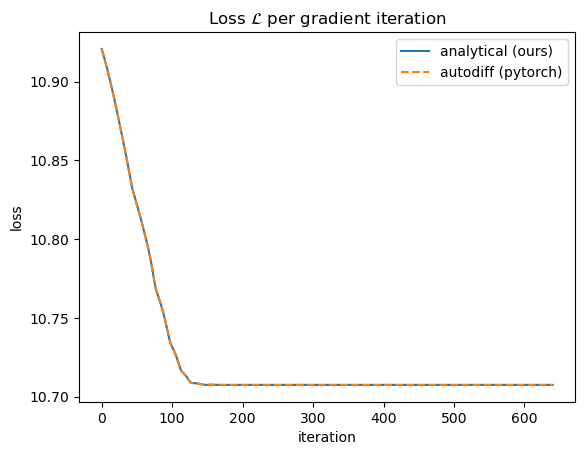

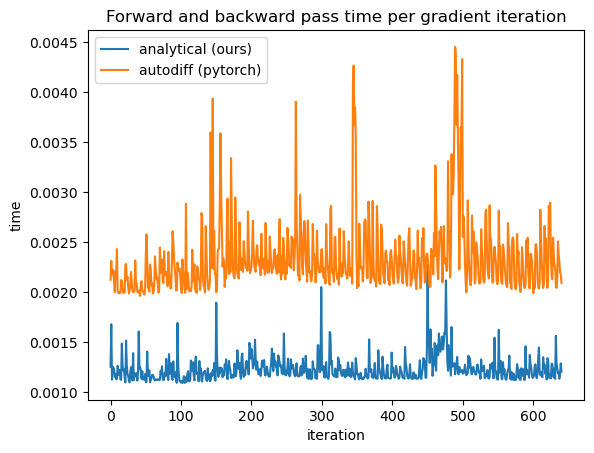

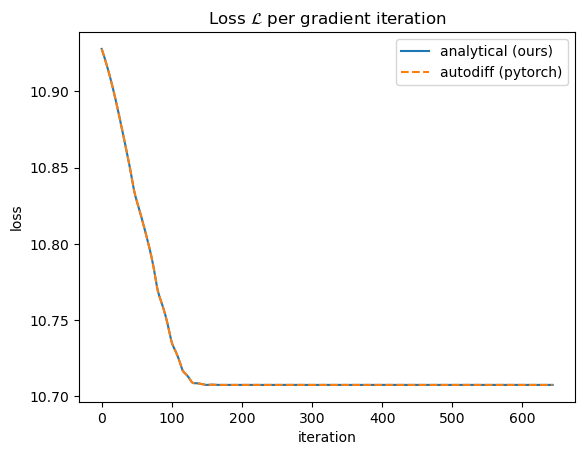

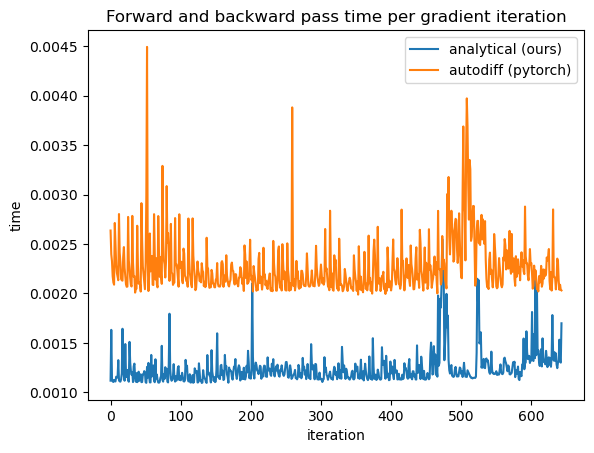

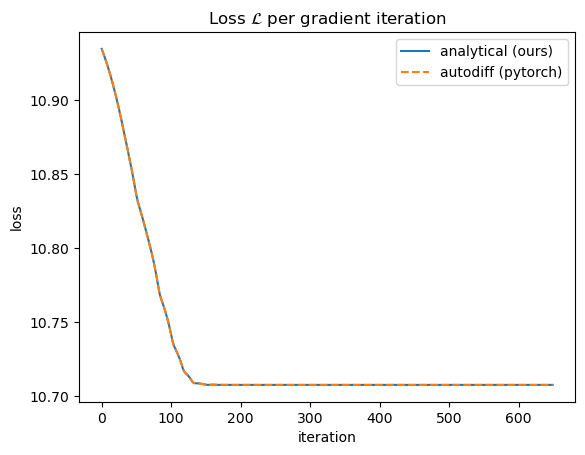

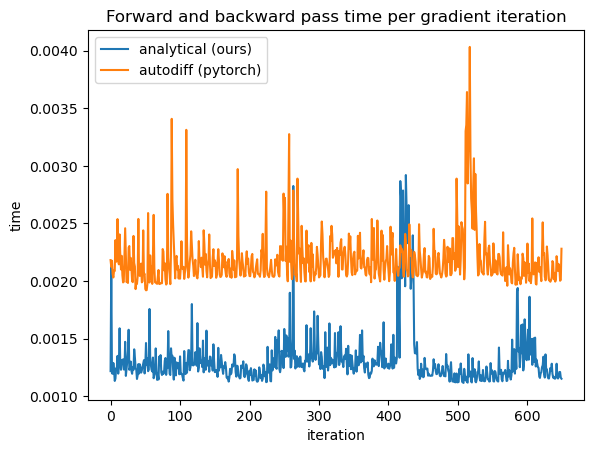

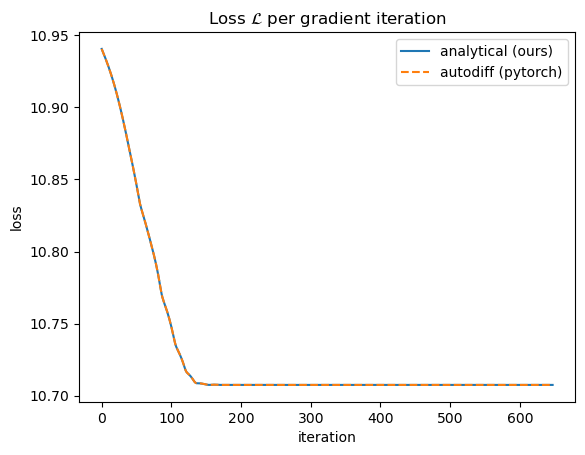

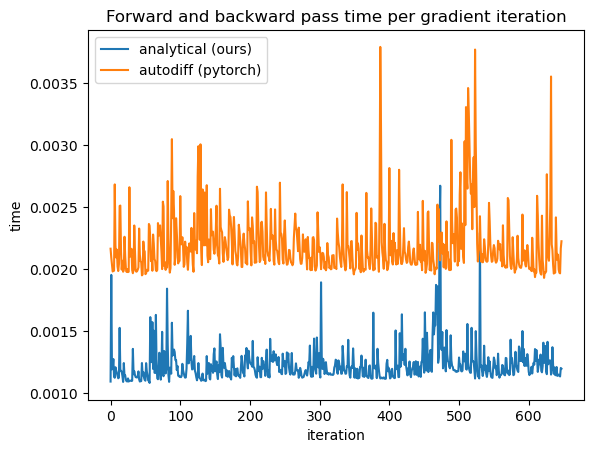

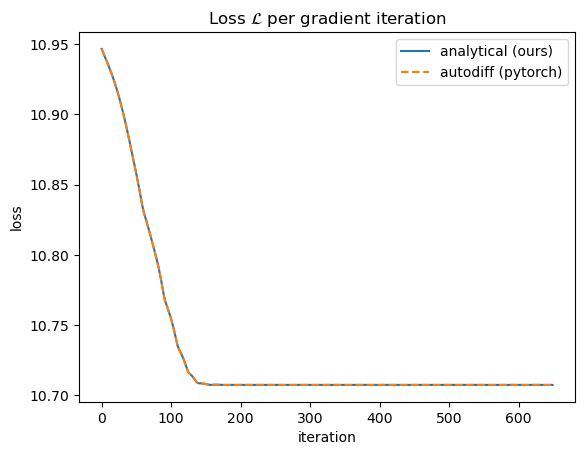

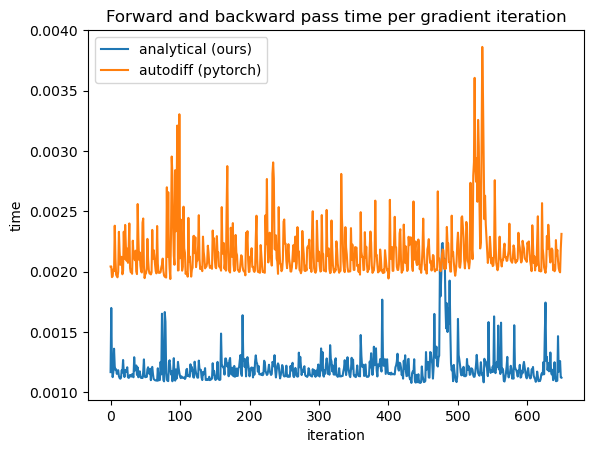

In [ ]:
# grads['analytical (ours)'] = []
# grads['autodiff (pytorch)'] = []
times['analytical (ours)'] = []
times['autodiff (pytorch)'] = []
losses['analytical (ours)'] = []
losses['autodiff (pytorch)'] = []

for winlength in range(start, support, pas):
    print(winlength)
    # grads['analytical (ours)'] += grads[winlength]['analytical (ours)']
    # grads['autodiff (pytorch)'] += grads[winlength]['autodiff (pytorch)']

    times['analytical (ours)'] += times[winlength]['analytical (ours)']
    times['autodiff (pytorch)'] += times[winlength]['autodiff (pytorch)']

    losses['analytical (ours)'] += losses[winlength]['analytical (ours)']
    losses['autodiff (pytorch)'] += losses[winlength]['autodiff (pytorch)']

    # plt.figure()
    # plt.title('gradients')
    # plt.plot(grads[winlength]['analytical (ours)'], label='analytical (ours)')
    # plt.plot(grads[winlength]['autodiff (pytorch)'], '--', label='autodiff (pytorch)')
    # plt.legend()

    plt.figure()
    plt.title('Loss $\mathcal{L}$ per gradient iteration')
    plt.ylabel('loss')
    # plt.semilogy(format='.3f')
    # plt.yticks([10**1, 10**2])
    plt.xlabel('iteration')
    plt.plot(losses[winlength]['analytical (ours)'], label='analytical (ours)')
    plt.plot(
        losses[winlength]['autodiff (pytorch)'],
        '--',
        label='autodiff (pytorch)',
    )
    plt.legend()

    plt.figure()
    plt.title('Forward and backward pass time per gradient iteration')
    plt.ylabel('time')
    plt.xlabel('iteration')
    plt.plot(times[winlength]['analytical (ours)'], label='analytical (ours)')
    plt.plot(
        times[winlength]['autodiff (pytorch)'], label='autodiff (pytorch)'
    )
    plt.legend()

    # f"times {np.mean(times[winlength]['analytical (ours)']):.5f}, {np.mean(times[winlength]['autodiff (pytorch)']):.5f}"

In [ ]:
print(np.mean(times['analytical (ours)']), np.std(times['analytical (ours)']))
print(
    np.mean(times['autodiff (pytorch)']), np.std(times['autodiff (pytorch)'])
)
print(
    np.mean(losses['analytical (ours)']), np.std(losses['analytical (ours)'])
)
print(
    np.mean(losses['autodiff (pytorch)']), np.std(losses['autodiff (pytorch)'])
)

print(
    np.mean(times['autodiff (pytorch)']) / np.mean(times['analytical (ours)'])
)
relative = []
relatives2 = []
for i in range(len(losses['analytical (ours)'])):
    relatives2.append(
        np.abs(
            losses['analytical (ours)'][i] - losses['autodiff (pytorch)'][i]
        )
    )
    err = np.abs(
        losses['analytical (ours)'][i] - losses['autodiff (pytorch)'][i]
    ) / np.abs(losses['analytical (ours)'][i])
    relative.append(err)

print(len(relative))
print(np.mean(relative), np.std(relative))
print(np.mean(relatives2), np.std(relatives2))

0.0012072473000257443 0.0001651512795074652
0.002229429571662298 0.0006074728404747395
10.715056866254562 0.029576068458867948
10.715055938060209 0.02957413189609583
1.8467049556580128
21840
8.570044273520372e-05 0.0008185672394963758
0.0009282708168029785 0.008916239240869065


498


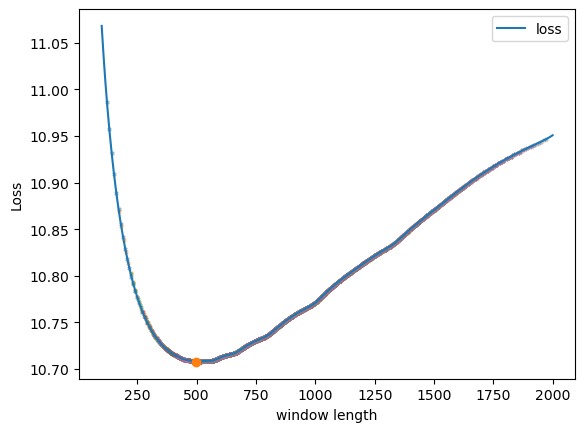

In [ ]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(
        x,
        win_length=win_length,
        support=support,
        stride=stride,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)

    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())


print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot([min_win], [min_err.item()], 'o')
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()

for winlength in range(start, support, pas):
    plt.scatter(
        wins[winlength]['analytical (ours)'],
        np.array(losses[winlength]['analytical (ours)']),
        marker='x',
        alpha=0.5,
        s=5,
    )

plt.show()

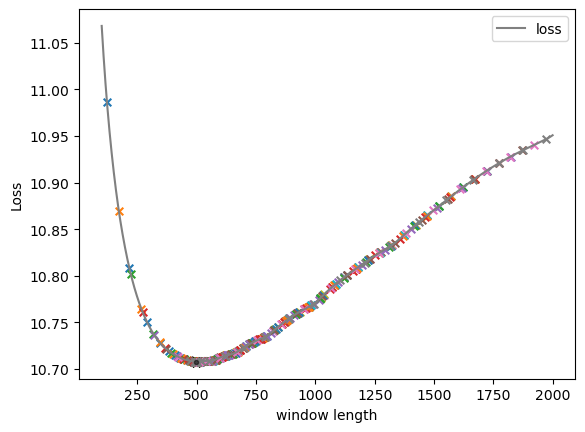

In [ ]:
plt.plot(range(100, support, 1), loss_function, label='loss', color='gray')
plt.plot([min_win], [min_err.item()], 'o', color='k', markersize=3, alpha=0.5)
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()

for winlength in range(start, support, pas):
    plt.scatter(
        wins[winlength]['analytical (ours)'][::10],
        np.array(losses[winlength]['analytical (ours)'][::10]),
        marker='x',
        s=30,
    )

plt.show()

In [ ]:
aa

NameError: name 'aa' is not defined

In [ ]:
# key = 'pytorch'
# winlengths[key] = []
# grads[key] = []
# times[key] = []

# dstft = FDSTFT(x, win_length=winlength, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
# params = [{'params': dstft.win_length,    'lr': lr}, ]
# opt = torch.optim.Adam(params)
# sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

# min_err = 100
# min_win = 0

# for epoch in range(epochs):

#     opt.zero_grad()
#     spec, stft, *_ = dstft(x)
#     err = entropy_loss(spec)
#     start_time = time.time()
#     err.backward()
#     dt = time.time() - start_time
#     opt.step()
#     sch.step(err)

#     winlengths[key].append(dstft.win_length.item())
#     grads[key].append(dstft.win_length.grad.item())
#     times[key].append(np.log(dt))

#     if err < min_err:
#         min_err = err
#         min_win = dstft.win_length.item()

#     if opt.param_groups[0]['lr'] < threeshold:
#         break

# losses[key] = entropy_loss(spec).item()
# print(epoch, f'{dstft.win_length.item():.1f}')
# dstft.print(spec, x, bar=True, wins=False, weights=False)

In [ ]:
# key = 'ours'
# winlengths[key] = []
# grads[key] = []
# times[key] = []

# dstft = FDSTFT(x, win_length=winlength, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
# params = [{'params': dstft.win_length,    'lr': lr}, ]
# opt = torch.optim.Adam(params)
# sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

# min_err = 100
# min_win = 0

# for epoch in range(epochs):

#     opt.zero_grad()
#     spec, stft, *_ = dstft(x)
#     err = entropy_loss(spec)
#     start_time = time.time()
#     dl_ds = torch.autograd.grad(err, stft)[0]
#     dl_dp = dstft.backward(x, dl_ds)
#     dt = time.time() - start_time
#     dstft.win_length.grad = dl_dp
#     opt.step()
#     sch.step(err)

#     winlengths[key].append(dstft.win_length.item())
#     grads[key].append(dstft.win_length.grad.item())
#     times[key].append(np.log(dt))

#     if err < min_err:
#         min_err = err
#         min_win = dstft.win_length.item()

#     if opt.param_groups[0]['lr'] < threeshold:
#         break

# losses[key] = entropy_loss(spec).item()
# print(epoch, f'{dstft.win_length.item():.1f}')
# dstft.print(spec, x, bar=True, wins=False, weights=False)

In [ ]:
# plt.figure()
# for key in winlengths.keys():
#     plt.plot(winlengths[key], label=key)
# plt.legend()

# plt.figure()
# for key in grads.keys():
#     plt.plot(grads[key], label=key)
# plt.legend()

# plt.figure()
# for key in times.keys():
#     plt.plot(times[key], label=key)
# plt.legend()
# plt.title(f""" pytorch mean : {np.mean(times['pytorch']):.4f} sum : {np.sum(times['pytorch']):.3f} \n ours   mean : {np.mean(times['ours']):.4f} sum : {np.sum(times['ours']):.3f}""");


In [ ]:
# loss_function = []
# min_err = 100
# min_win = 0

# for win_length in range(490, 510, 1):
#     dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
#     spec, stft, *_ = dstft(x)
#     err = entropy_loss(spec)

#     if err < min_err:
#         min_err = err
#         min_win = win_length
#     loss_function.append(err.cpu())

# print(min_win)
# plt.plot(range(490, 510, 1), loss_function, label='loss')
# plt.plot(min_win, min_err.cpu(), 'o', label='min')
# plt.plot(winlengths['pytorch'][-1], losses['pytorch'], 'o', alpha=.8, label='pytorch')
# plt.plot(winlengths['ours'][-1], losses['ours'], 'o', alpha=.8, label='ours')
# plt.xlabel('window length')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# pytorch_grads = []
# ours = []

# dstft = FDSTFT(x, win_length=900, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
# params = [{'params': dstft.win_length,    'lr': lr}, ]
# opt = torch.optim.Adam(params)
# sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=patience, verbose=True)

# min_err = 100
# min_win = 0

# for epoch in range(epochs):

#     opt.zero_grad()
#     spec, stft, *_ = dstft(x)
#     err = entropy_loss(spec)
#     err.backward()
#     pytorch_grads.append(dstft.win_length.grad.item())


#     opt.zero_grad()
#     spec, stft, *_ = dstft(x)
#     err = entropy_loss(spec)
#     dl_ds = torch.autograd.grad(err, stft)[0]
#     #print(dl_ds, )

#     dl_dp = dstft.backward(x, dl_ds)
#     dstft.win_length.grad = dl_dp
#     ours.append(dstft.win_length.grad.item())
#     opt.step()
#     sch.step(err)


#     if err < min_err:
#         min_err = err
#         min_win = dstft.win_length.item()

#     if opt.param_groups[0]['lr'] < threeshold:
#         break

# losses[key] = entropy_loss(spec).item()
# print(epoch, f'{dstft.win_length.item():.1f}')
# dstft.print(spec, x, bar=True, wins=False, weights=False)


# relative = []
# for i in range(len(ours)):
#     err = np.abs(ours[i] - pytorch_grads[i]) / np.abs(ours[i])
#     relative.append(err)


# plt.figure()
# plt.plot(ours, label='analytical (ours)')
# plt.plot(pytorch_grads, label='AD (Pytorch)')


# plt.figure('erreur relative')
# plt.plot(relative, label='relative error')

In [ ]:
def dentropy_loss(x11, entropy):
    x = torch.abs(x11)
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    s = x1.sum(dim=-1)
    probs = torch.div(x1.T, s).T  # B, N
    # entropy = -(probs * torch.clamp(torch.log(probs),
    #            min=torch.finfo(x.dtype).min)).sum(dim=-1)  # B
    # print(probs.shape, entropy.shape, s.shape, x1.shape, x.shape)
    out = (
        -torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min) - entropy
    ) / s
    # print(out.shape)
    out = out.reshape_as(x) * x11 / x

    return out

In [ ]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(
        x,
        win_length=win_length,
        support=support,
        stride=stride,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)

    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())

print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot([min_win], [min_err.item()], 'o')
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
relative = []
for winlength in range(111, support, 500):
    pytorch_grads = []
    pytorch_grads2 = []
    ours = []
    rapport = []
    time_ours = []
    time_p = []

    dstft = FDSTFT(
        x,
        win_length=winlength,
        support=support,
        stride=stride,
        win_requires_grad=True,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    params = [{'params': dstft.win_length, 'lr': lr}]
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=opt, mode='min', factor=0.1, patience=patience, verbose=False
    )

    min_err = 100
    min_win = 0

    for epoch in range(1000):
        opt.zero_grad()
        spec, stft, *_ = dstft(x)
        # err = entropy_loss(spec)

        x1 = torch.reshape(spec, (spec.shape[0], -1))  # B, N
        x1sum = x1.sum(dim=-1)
        probs = torch.div(x1.T, x1sum).T  # B, N
        log_probs = torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
        entropy = -(probs * log_probs).sum(dim=-1)  # B
        err = entropy.mean()

        start_time = time.time()
        err.backward()
        dt = time.time() - start_time
        pytorch_grads.append(dstft.win_length.grad.item())
        time_p.append(np.log(dt))

        with torch.no_grad():
            # dl_ds2 = dentropy_loss(stft)
            start_time = time.time()
            dl_ds = (-(log_probs + err) / x1sum).reshape_as(spec) * stft / spec
            dl_dp = dstft.backward(x, dl_ds)
            dt = time.time() - start_time
            time_ours.append(np.log(dt))
            ours.append(dl_dp.item())

        opt.step()
        sch.step(err)

        # print(dstft.win_length.grad.item())
        # print(spec.grad.item())

        # opt.zero_grad()
        # spec, stft, *_ = dstft(x)
        # err = entropy_loss(spec)
        # dl_ds = torch.autograd.grad(err, stft)[0]
        # print(dl_ds)
        # ds_dp = torch.zeros_like(stft)
        # for f in range(stft.shape[-2]):
        #    for t in range(stft.shape[-1]):
        #        opt.zero_grad()
        #        ds_dp[:, f, t] = torch.autograd.grad(stft[:, f, t], dstft.win_length, retain_graph=True)[0]
        #        opt.zero_grad()
        #
        ##ds_dp = torch.autograd.grad(stft, dstft.win_length)[0]
        # dl_dp = (torch.conj(dl_ds) * ds_dp).sum().real.expand(dstft.win_length.shape)
        # dstft.win_length.grad = dl_dp

        # pytorch_grads2.append(dstft.win_length.grad.item())

        # opt.zero_grad()
        # spec, stft, *_ = dstft(x)
        # err = entropy_loss(spec)
        # dl_ds = torch.autograd.grad(err, stft)[0]
        # print('stft', stft)
        # dl_ds2 = dentropy_loss(stft)
        # error = (dl_ds - dl_ds2).abs().sum().item()
        # print(dl_ds, dl_ds2)
        # ours.append(error)
        # dl_dp = dstft.backward(x, dl_ds)

        # dstft.win_length.grad = dl_dp
        # ours.append(dstft.win_length.grad.item())
        # pytorch_grads2.append(dstft.N *dstft.win_length.grad.item()/dstft.actual_win_length.detach().cpu().item())

        # rapport.append(ours[-1] / pytorch_grads[-1])

        if err < min_err:
            min_err = err
            min_win = dstft.win_length.item()

        if opt.param_groups[0]['lr'] < threeshold:
            break

    print(winlength, epoch, f'{dstft.win_length.item():.1f}')
    dstft.print(spec, x, bar=True, wins=False, weights=False)

    # for i in range(len(ours)):
    #    #err = np.abs(ours[i] - pytorch_grads[i]) / (np.abs(ours[i]) + 0)
    #    err = np.abs(pytorch_grads[i] - pytorch_grads[i])
    #    relative.append(err)

    plt.figure(winlength)
    # plt.ylim(0, 0.1)
    plt.plot(ours, label='analytical (ours)')
    plt.plot(pytorch_grads, '--', label='AD (Pytorch)')
    # plt.plot(pytorch_grads2, '--', label='Analytical (ours)')
    # plt.plot(rapport)
    plt.legend()

    plt.figure()
    plt.plot(time_ours, label='analytical (ours)')
    plt.plot(time_p, label='AD (Pytorch)')
    # plt.plot(pytorch_grads2, '--', label='Analytical (ours)')
    # plt.plot(rapport)
    plt.legend()

# print(len(relative), np.mean(relative), np.std(relative))
# plt.figure('erreur relative')
# plt.plot(relative, label='relative error')

In [ ]:
mat = loadmat('../data/fan_flutter.mat')['x']
x = torch.from_numpy(mat).float().to(device)  # [:, 4_000:10_000]
print(x.shape)

In [ ]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(
        x,
        win_length=win_length,
        support=support,
        stride=stride,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)

    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())

print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot([min_win], [min_err.item()], 'o')
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
relative = []
for winlength in range(111, support, 500):
    pytorch_grads = []
    pytorch_grads2 = []
    ours = []
    rapport = []
    time_ours = []
    time_p = []

    dstft = FDSTFT(
        x,
        win_length=winlength,
        support=support,
        stride=stride,
        win_requires_grad=True,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    params = [{'params': dstft.win_length, 'lr': lr}]
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=opt, mode='min', factor=0.1, patience=patience, verbose=False
    )

    min_err = 100
    min_win = 0

    for epoch in range(1000):
        opt.zero_grad()
        spec, stft, *_ = dstft(x)
        # err = entropy_loss(spec)

        x1 = torch.reshape(spec, (spec.shape[0], -1))  # B, N
        x1sum = x1.sum(dim=-1)
        probs = torch.div(x1.T, x1sum).T  # B, N
        log_probs = torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
        entropy = -(probs * log_probs).sum(dim=-1)  # B
        err = entropy.mean()

        start_time = time.time()
        err.backward()
        dt = time.time() - start_time
        pytorch_grads.append(dstft.win_length.grad.item())
        time_p.append(np.log(dt))

        with torch.no_grad():
            # dl_ds2 = dentropy_loss(stft)
            start_time = time.time()
            dl_ds = (-(log_probs + err) / x1sum).reshape_as(spec) * stft / spec
            dl_dp = dstft.backward(x, dl_ds)
            dt = time.time() - start_time
            time_ours.append(np.log(dt))
            ours.append(dl_dp.item())

        opt.step()
        sch.step(err)

        # print(dstft.win_length.grad.item())
        # print(spec.grad.item())

        # opt.zero_grad()
        # spec, stft, *_ = dstft(x)
        # err = entropy_loss(spec)
        # dl_ds = torch.autograd.grad(err, stft)[0]
        # print(dl_ds)
        # ds_dp = torch.zeros_like(stft)
        # for f in range(stft.shape[-2]):
        #    for t in range(stft.shape[-1]):
        #        opt.zero_grad()
        #        ds_dp[:, f, t] = torch.autograd.grad(stft[:, f, t], dstft.win_length, retain_graph=True)[0]
        #        opt.zero_grad()
        #
        ##ds_dp = torch.autograd.grad(stft, dstft.win_length)[0]
        # dl_dp = (torch.conj(dl_ds) * ds_dp).sum().real.expand(dstft.win_length.shape)
        # dstft.win_length.grad = dl_dp

        # pytorch_grads2.append(dstft.win_length.grad.item())

        # opt.zero_grad()
        # spec, stft, *_ = dstft(x)
        # err = entropy_loss(spec)
        # dl_ds = torch.autograd.grad(err, stft)[0]
        # print('stft', stft)
        # dl_ds2 = dentropy_loss(stft)
        # error = (dl_ds - dl_ds2).abs().sum().item()
        # print(dl_ds, dl_ds2)
        # ours.append(error)
        # dl_dp = dstft.backward(x, dl_ds)

        # dstft.win_length.grad = dl_dp
        # ours.append(dstft.win_length.grad.item())
        # pytorch_grads2.append(dstft.N *dstft.win_length.grad.item()/dstft.actual_win_length.detach().cpu().item())

        # rapport.append(ours[-1] / pytorch_grads[-1])

        if err < min_err:
            min_err = err
            min_win = dstft.win_length.item()

        if opt.param_groups[0]['lr'] < threeshold:
            break

    print(winlength, epoch, f'{dstft.win_length.item():.1f}')
    dstft.print(spec, x, bar=True, wins=False, weights=False)

    # for i in range(len(ours)):
    #    #err = np.abs(ours[i] - pytorch_grads[i]) / (np.abs(ours[i]) + 0)
    #    err = np.abs(pytorch_grads[i] - pytorch_grads[i])
    #    relative.append(err)

    plt.figure(winlength)
    # plt.ylim(0, 0.1)
    plt.plot(ours, label='analytical (ours)')
    plt.plot(pytorch_grads, '--', label='AD (Pytorch)')
    # plt.plot(pytorch_grads2, '--', label='Analytical (ours)')
    # plt.plot(rapport)
    plt.legend()

    plt.figure()
    plt.plot(time_ours, label='analytical (ours)')
    plt.plot(time_p, label='AD (Pytorch)')
    # plt.plot(pytorch_grads2, '--', label='Analytical (ours)')
    # plt.plot(rapport)
    plt.legend()

# print(len(relative), np.mean(relative), np.std(relative))
# plt.figure('erreur relative')
# plt.plot(relative, label='relative error')

In [ ]:
mat = loadmat('../data/x_vitesse2.mat')['xt']
x = torch.from_numpy(mat).float().to(device)  # [:, 38_000:60_000]
stride = 50
support = 2_000
print(x.shape)

In [ ]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(
        x,
        win_length=win_length,
        support=support,
        stride=stride,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)

    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())

print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot([min_win], [min_err.item()], 'o')
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
relative = []
for winlength in range(111, support, 500):
    pytorch_grads = []
    pytorch_grads2 = []
    ours = []
    rapport = []
    time_ours = []
    time_p = []

    dstft = FDSTFT(
        x,
        win_length=winlength,
        support=support,
        stride=stride,
        win_requires_grad=True,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    params = [{'params': dstft.win_length, 'lr': lr}]
    opt = torch.optim.Adam(params)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=opt, mode='min', factor=0.1, patience=patience, verbose=False
    )

    min_err = 100
    min_win = 0

    for epoch in range(1000):
        opt.zero_grad()
        spec, stft, *_ = dstft(x)
        # err = entropy_loss(spec)

        x1 = torch.reshape(spec, (spec.shape[0], -1))  # B, N
        x1sum = x1.sum(dim=-1)
        probs = torch.div(x1.T, x1sum).T  # B, N
        log_probs = torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
        entropy = -(probs * log_probs).sum(dim=-1)  # B
        err = entropy.mean()

        start_time = time.time()
        err.backward()
        dt = time.time() - start_time
        pytorch_grads.append(dstft.win_length.grad.item())
        time_p.append(np.log(dt))

        with torch.no_grad():
            # dl_ds2 = dentropy_loss(stft)
            start_time = time.time()
            dl_ds = (-(log_probs + err) / x1sum).reshape_as(spec) * stft / spec
            dl_dp = dstft.backward(x, dl_ds)
            dt = time.time() - start_time
            time_ours.append(np.log(dt))
            ours.append(dl_dp.item())

        opt.step()
        sch.step(err)

        # print(dstft.win_length.grad.item())
        # print(spec.grad.item())

        # opt.zero_grad()
        # spec, stft, *_ = dstft(x)
        # err = entropy_loss(spec)
        # dl_ds = torch.autograd.grad(err, stft)[0]
        # print(dl_ds)
        # ds_dp = torch.zeros_like(stft)
        # for f in range(stft.shape[-2]):
        #    for t in range(stft.shape[-1]):
        #        opt.zero_grad()
        #        ds_dp[:, f, t] = torch.autograd.grad(stft[:, f, t], dstft.win_length, retain_graph=True)[0]
        #        opt.zero_grad()
        #
        ##ds_dp = torch.autograd.grad(stft, dstft.win_length)[0]
        # dl_dp = (torch.conj(dl_ds) * ds_dp).sum().real.expand(dstft.win_length.shape)
        # dstft.win_length.grad = dl_dp

        # pytorch_grads2.append(dstft.win_length.grad.item())

        # opt.zero_grad()
        # spec, stft, *_ = dstft(x)
        # err = entropy_loss(spec)
        # dl_ds = torch.autograd.grad(err, stft)[0]
        # print('stft', stft)
        # dl_ds2 = dentropy_loss(stft)
        # error = (dl_ds - dl_ds2).abs().sum().item()
        # print(dl_ds, dl_ds2)
        # ours.append(error)
        # dl_dp = dstft.backward(x, dl_ds)

        # dstft.win_length.grad = dl_dp
        # ours.append(dstft.win_length.grad.item())
        # pytorch_grads2.append(dstft.N *dstft.win_length.grad.item()/dstft.actual_win_length.detach().cpu().item())

        # rapport.append(ours[-1] / pytorch_grads[-1])

        if err < min_err:
            min_err = err
            min_win = dstft.win_length.item()

        if opt.param_groups[0]['lr'] < threeshold:
            break

    print(winlength, epoch, f'{dstft.win_length.item():.1f}')
    dstft.print(spec, x, bar=True, wins=False, weights=False)

    # for i in range(len(ours)):
    #    #err = np.abs(ours[i] - pytorch_grads[i]) / (np.abs(ours[i]) + 0)
    #    err = np.abs(pytorch_grads[i] - pytorch_grads[i])
    #    relative.append(err)

    plt.figure(winlength)
    # plt.ylim(0, 0.1)
    plt.plot(ours, label='analytical (ours)')
    plt.plot(pytorch_grads, '--', label='AD (Pytorch)')
    # plt.plot(pytorch_grads2, '--', label='Analytical (ours)')
    # plt.plot(rapport)
    plt.legend()

    plt.figure()
    plt.plot(time_ours, label='analytical (ours)')
    plt.hlines(np.mean(time_ours), xmin=0, xmax=300)
    plt.plot(time_p, label='AD (Pytorch)')
    plt.hlines(np.mean(time_p), xmin=0, xmax=300, colors='orange')
    # plt.plot(pytorch_grads2, '--', label='Analytical (ours)')
    # plt.plot(rapport)
    plt.legend()


# print(len(relative), np.mean(relative), np.std(relative))
# plt.figure('erreur relative')
# plt.plot(relative, label='relative error')